# Champions League Match Prediction
Now that we have a clean dataset, we will use it to predict the if a team is going to win a champions league match or not.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import pickle
import plotly.express as px


pd.set_option('display.max_columns', 100)

# Loading data
Setting up the target coloumn and make ready for train test. The results are not balanced. Champions Leageue teams win most of their domestic league matches too. 

In [2]:
df = pickle.load(open('clean_df.pkl', 'rb'))
df = df.sort_values("date")
df=df.reset_index(drop=True)
df['venue'] = df['venue'].apply(lambda x:'Away' if x =='Neutral' else x) # Adding neutral ground to away.
df['target'] = df['result']. apply(lambda x: 1 if x=='W' else (0 if x=='L' else 2) )
#df = df.loc[df['comp']=='Champions Lg'].copy() # Only champions league matches.
print(df['target'].value_counts())
print(df.shape)

1    1950
0     828
2     711
Name: target, dtype: int64
(3489, 71)


As can be seen from above, the result column is not balanced. Also, according to our brief of predicting if the game is going ot be a win or "not", we will have a binary target column, the result is either a win or loss. Te reason the number of wins is a lot higher than the losses and draws is that these tea have qualified for the Champions League. The qualifying teams win the majority of their games in the domestic leagues as well. 

In [3]:
df['target'] = (df['result'] == "W").astype("int")
df.target.value_counts() # A little more balanced

1    1950
0    1539
Name: target, dtype: int64

In [22]:
1950/(1950+1539)

0.5588993981083406

# Defining functions
- train_test
- rolling_averages - (Feature Engineering)
- rolling_constructor - (Feature Engineering)
- infer

In [4]:
def rolling_averages(group, cols, new_cols,h): # Feature Engineering by rolling averages, h is the horizon for this 3 games, 4 games etc.
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(h,closed="left").mean() # closed = left -> to avoid data leakage from future matches 5 matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group

In [5]:
def rolling_constructor(cols,data,h): #constructs a rolling avergae data from using the rolling avergae function. Grouping by team to get the latest average stats.
    new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names
    df_rolling = data.groupby('team').apply(lambda x: rolling_averages(x,cols, new_cols, h))
    df_rolling = df_rolling.droplevel('team')
    return df_rolling, new_cols

In [6]:
def train_test(model, data, features, *args): # Function to tran and test, returns fitted model
    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]

    if 'sample_weight' in args: #get sample weights in case using xgboost
        sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=train['target'] #provide your own target name
        )
        #print(sample_weights)
        
        model.fit(train[features],train['target'],sample_weight=sample_weights )
    else:
        model.fit(train[features],train['target'])

    predictions = model.predict(test[features])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
    print(pd.crosstab(index=combined["actual"], columns=combined["predicted"]))


    fig,ax = plt.subplots(1,2, figsize = (20,10))
    ConfusionMatrixDisplay.from_estimator(model, test[features],
                                          test["target"], display_labels=['won','not won'],
                                          cmap=plt.cm.Blues, normalize='true', ax =ax[0])

    imp = model.feature_importances_
    importance = pd.Series(data=imp,
                            index=  features)
    # Sort importances
    importances_sorted = importance.sort_values()
    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='blue', ax = ax[1])
    plt.title('Features Importances')
    plt.show()

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    print('The weighted percision is',precision_weight)
    print('The raw percision is: ',precision_raw)

    return combined, precision_weight, precision_raw, model

In [54]:
def infer(selected_team,selected_opponent, v_code, data, model,features): #inference function, returns 0, 1, 2 for loss, win and draw
    '''Procedure for inference:
        - Get the features and split in two based on if they are for the home team or opposing team (f_h and f_opp)
        - Get the latest match of the team in the dataframe, and select the features orm the hoe team.
        - We need ot construct th eopposing team sub-dataframe to feed for inference. We need to now select the opposing team as home team (like above), change the feature names and take the "_opp" out, and find out the features for the opposing team. We then need to add those in the place of the opposing team features. 
        - This way when we flip the teams, the opposing and home teams will be flipped and we would not make a mistake again. 
    '''
    # split the features to home and opposing
    f_h = [f for f in features if "_opp" not in f] #Home team features
    f_opp = [f for f in features if "_opp" in f] #Opposing team features
    # Note that the opposing team features, for inference have to be the team features where the team is the opposing team.
    f_opp_p = [s.replace('_opp','') for s in f_opp] #opposing team features processed.
    ## Setting up the data to be fed into the model.
    hm_df = data[data['team'] == selected_team].tail(1) # get the last game row for the home team. It has the latest rolling stats.
    hm_df = hm_df[f_h].copy()
    # Get the stats for th eopposing team
    op_df = data[data['team'] == selected_opponent].tail(1) # Get the last game for the selected opponent, latest rolling stats
    op_df = op_df[f_opp_p].copy()
    # construcing the inference dataframe
    infer_df = hm_df
    infer_df[f_opp] = op_df.values #Placing the values we extracted for the opposing team under the correct column names in the infer dataframe
    infer_df['opp_code'] = int(data[data['opponent']==selected_opponent]['opp_code'].head(1)) # Adding the correct opp_code 
    infer_df['venue_code'] = v_code # adding the correct venue code (home away, 1,0)
    print(infer_df)
    inference = model.predict(infer_df[features])
    return inference

## First model

predicted    0    1
actual             
0          234  143
1          215  271


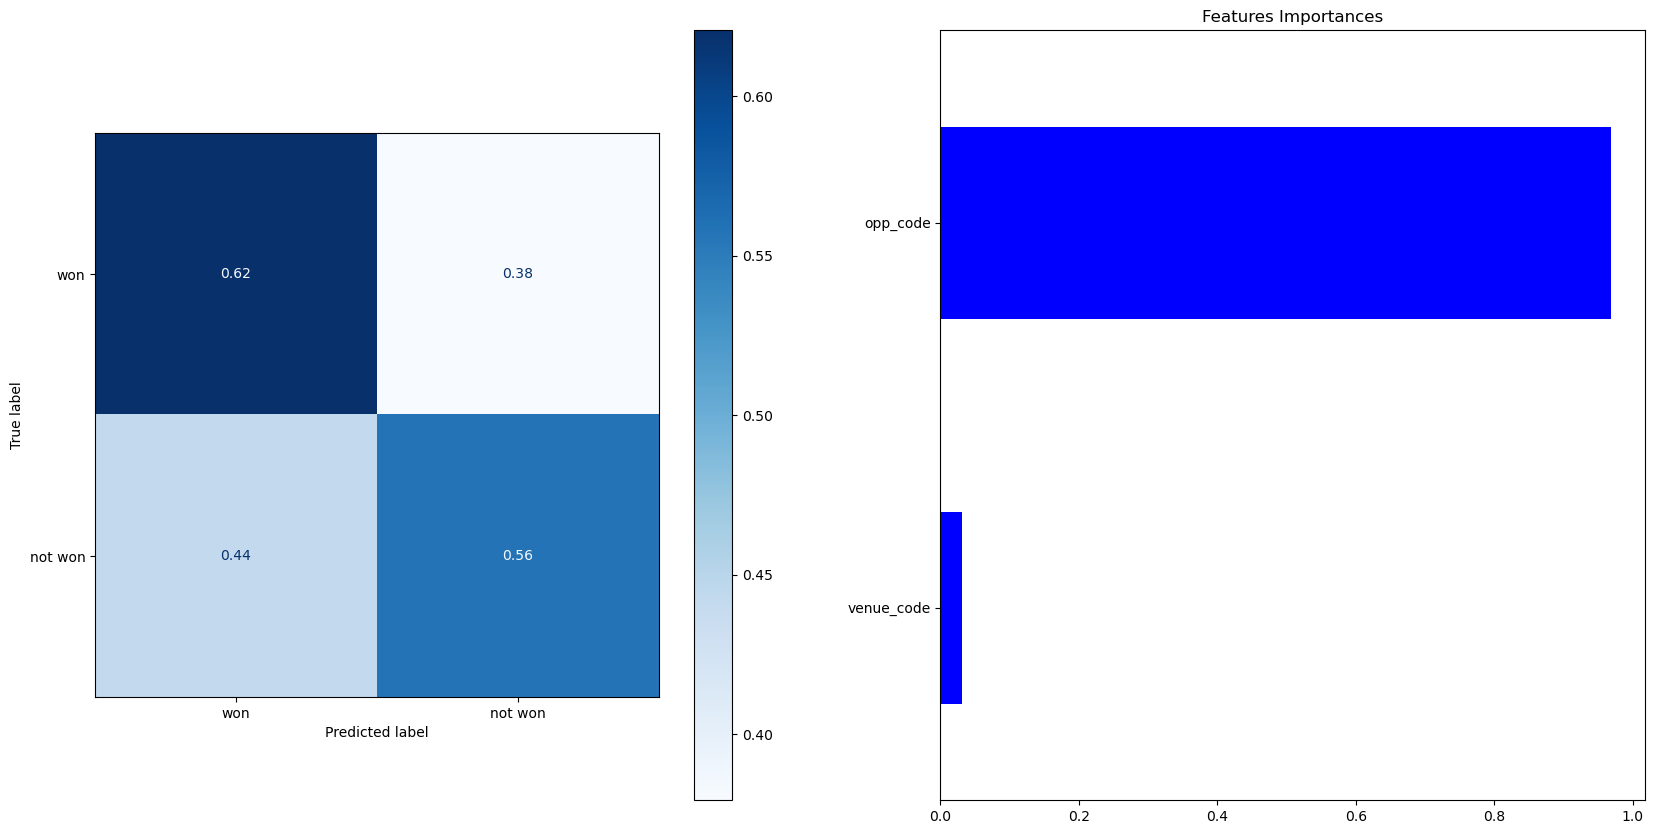

The weighted percision is 0.596300173211982
The raw percision is:  [0.52115813 0.65458937]


In [8]:
predictors = ["venue_code", "opp_code"] # initial predictors 

rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df,predictors)

# Feature Engineering using rollaing averages form the previous games

predicted    0    1
actual             
0          126  236
1          108  367


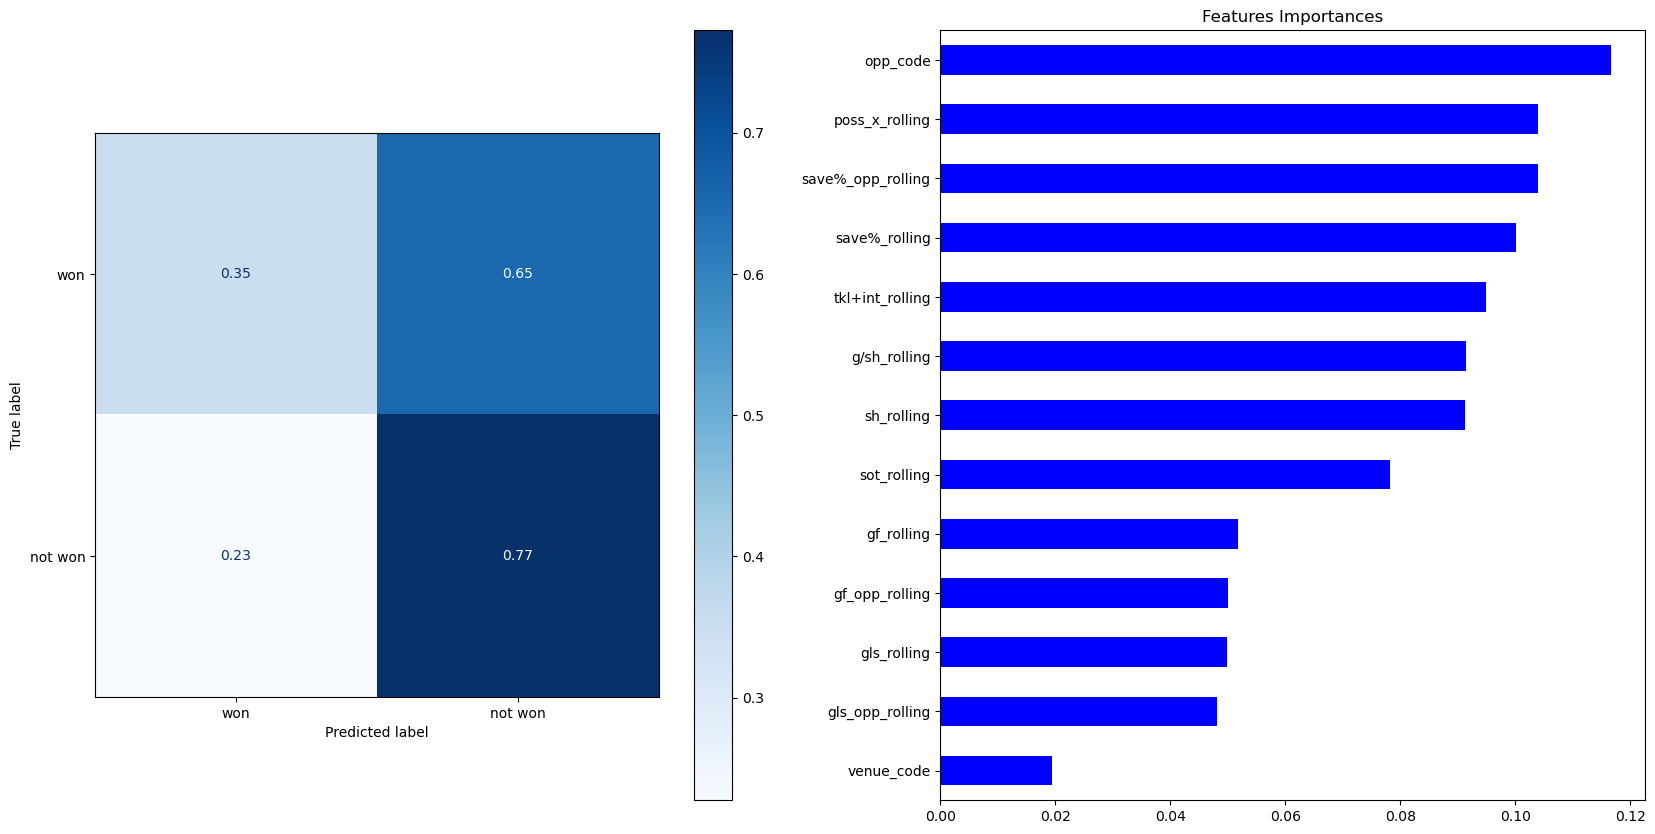

The weighted percision is 0.5782786889618323
The raw percision is:  [0.53846154 0.60862355]


In [9]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
df_rolling, new_cols = rolling_constructor(cols, df, 5)
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df_rolling,predictors + new_cols)

More features

predicted    0    1
actual             
0          124  238
1           96  379


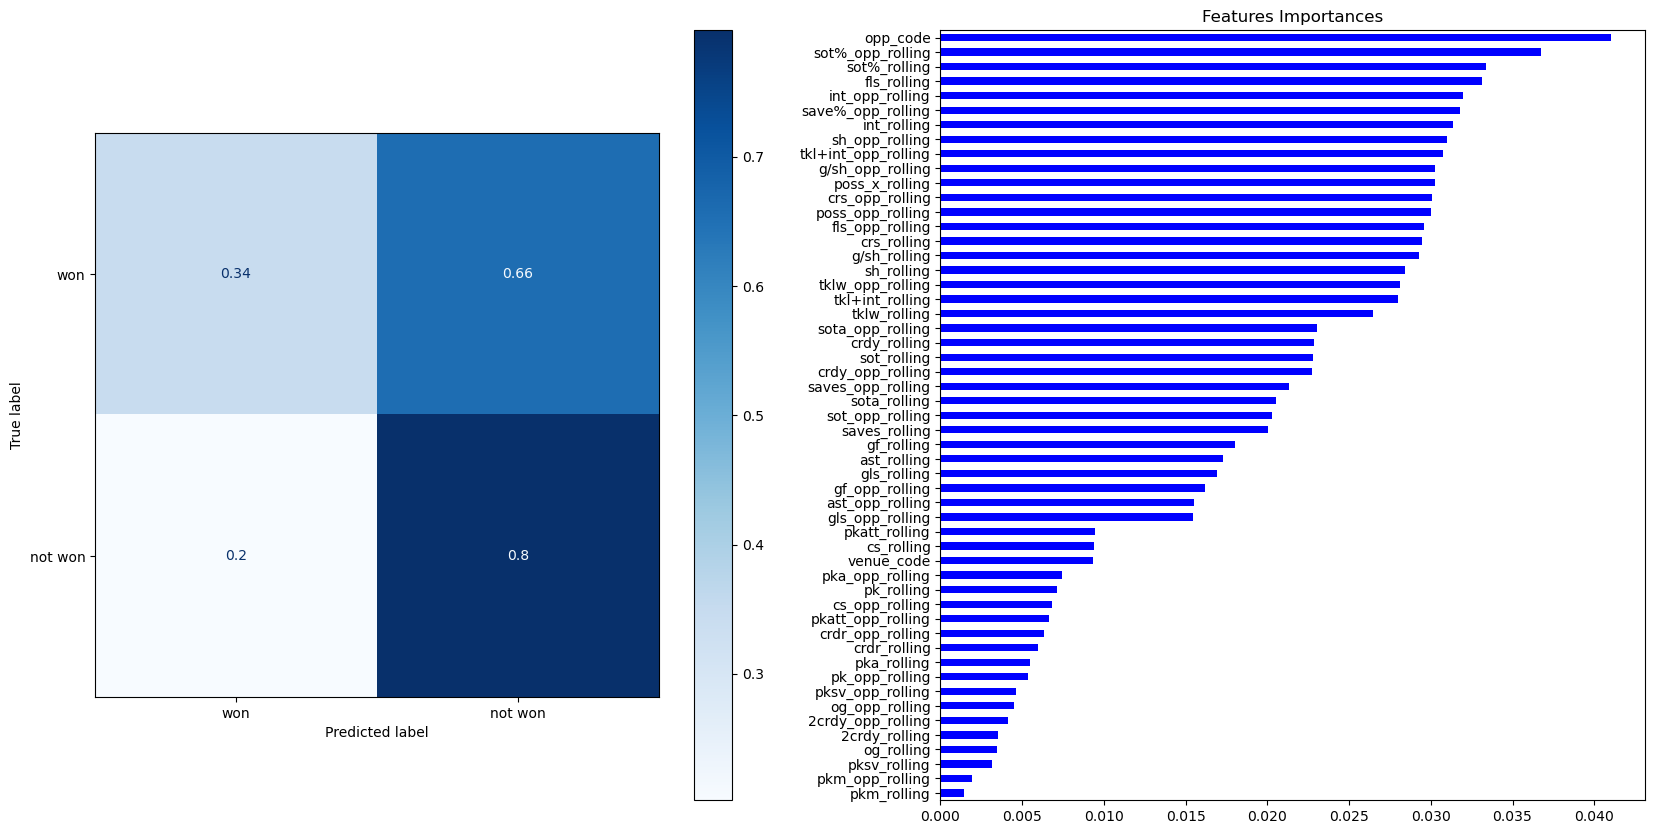

The weighted percision is 0.5923668817274714
The raw percision is:  [0.56363636 0.61426256]


In [10]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

df_rolling, new_cols = rolling_constructor(cols, df, 5)
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df_rolling,predictors + new_cols)

In [11]:
df.team.unique()

array(['Club Brugge', 'Krasnodar', 'Zenit', 'Lokomotiv Moscow', 'Rennes',
       'Marseille', 'Paris Saint Germain', 'Midtjylland', 'RB Leipzig',
       'Liverpool', 'Ajax', 'Red Bull Salzburg', 'Chelsea',
       'Istanbul Basaksehir', 'Dortmund', 'Bayern Munich',
       'Monchengladbach', 'Porto', 'Manchester United', 'Real Madrid',
       'Juventus', 'Manchester City', 'Dynamo Kyiv', 'Olympiacos',
       'Ferencvaros', 'Internazionale', 'Atalanta', 'Lazio', 'Sevilla',
       'Barcelona', 'Atletico Madrid', 'Shakhtar Donetsk', 'Young Boys',
       'Lille', 'Sporting CP', 'Benfica', 'Wolfsburg', 'Villarreal',
       'Sheriff Tiraspol', 'Besiktas', 'Milan', 'Dinamo Zagreb',
       'FC Copenhagen', 'Viktoria Plzen', 'Bayer Leverkusen', 'Rangers',
       'Celtic', 'Eintracht Frankfurt', 'Tottenham Hotspur', 'Napoli',
       'Maccabi Haifa'], dtype=object)

## XGBoost

In [12]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

df_rolling, new_cols = rolling_constructor(cols, df, 4)

#Using minmax scaling to prepare for XGBoost. 
df_rolling[new_cols] = (df_rolling[new_cols]-df_rolling[new_cols].min())/(df_rolling[new_cols].max()-df_rolling[new_cols].min())

predicted    0    1
actual             
0          180  186
1          190  290


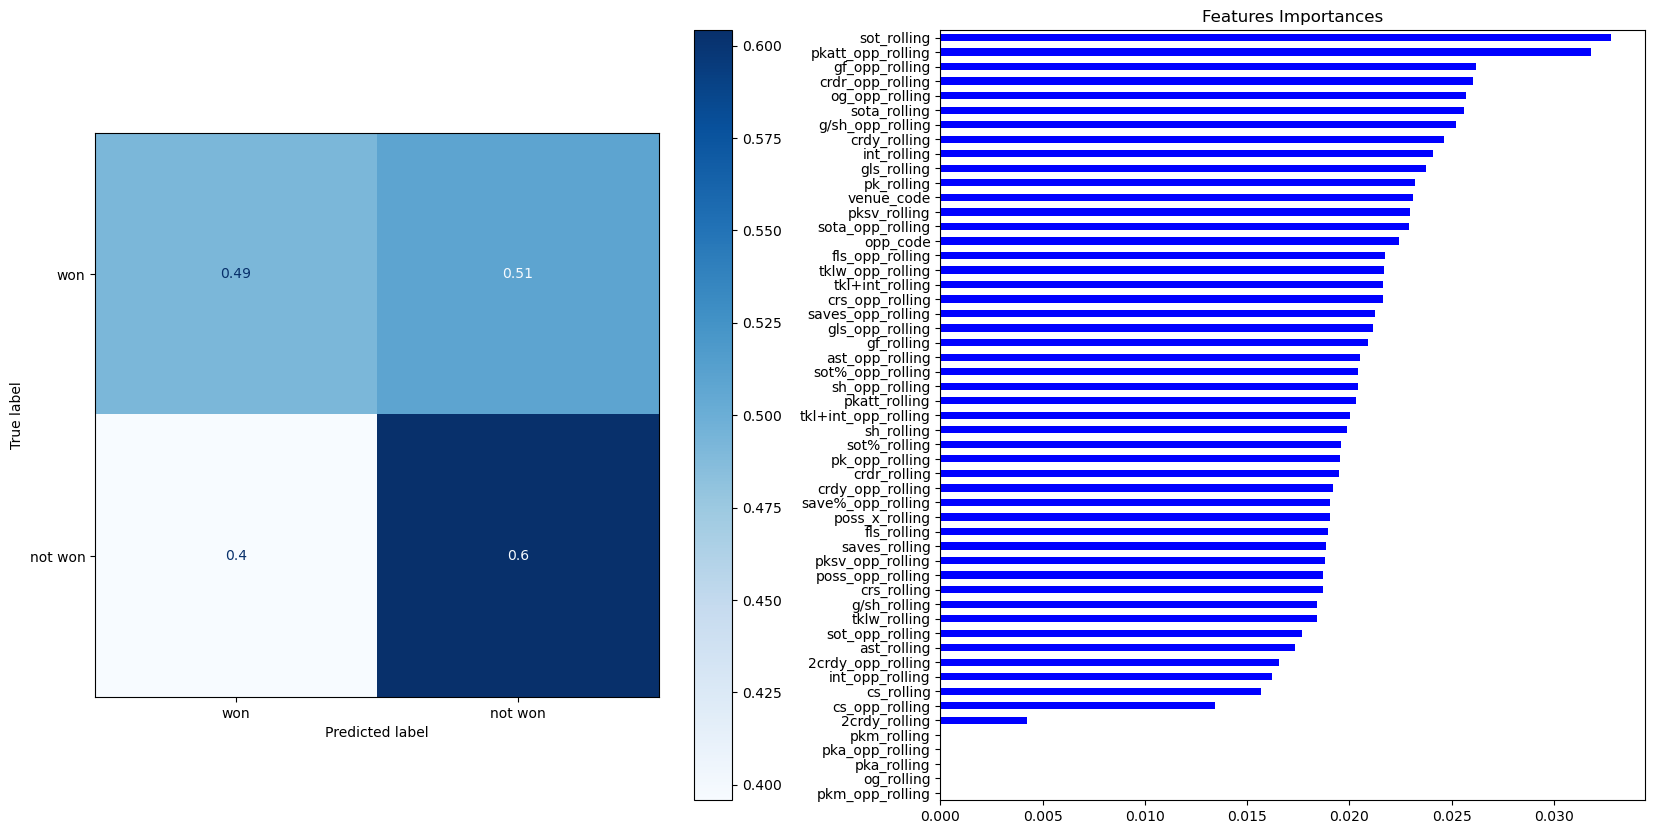

The weighted percision is 0.5561359679006738
The raw percision is:  [0.48648649 0.6092437 ]


In [31]:
#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='binary:logistic',
                              booster='gbtree',
                              eta = 0.1,
                              eval_metric='mlogloss',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.1,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              scale_pos_weight = 0.75,

                              )

combined, precision_weight, precision_raw, XGB_model = train_test(XGB_model,df_rolling, predictors + new_cols)

In [40]:
sorted_idx = XGB_model.feature_importances_.argsort()
imp = pd.DataFrame(XGB_model.feature_importances_, index = XGB_model.feature_names_in_)
trim_features = list(imp[imp[0]>0.021].index)

predicted    0    1
actual             
0          204  162
1          186  294


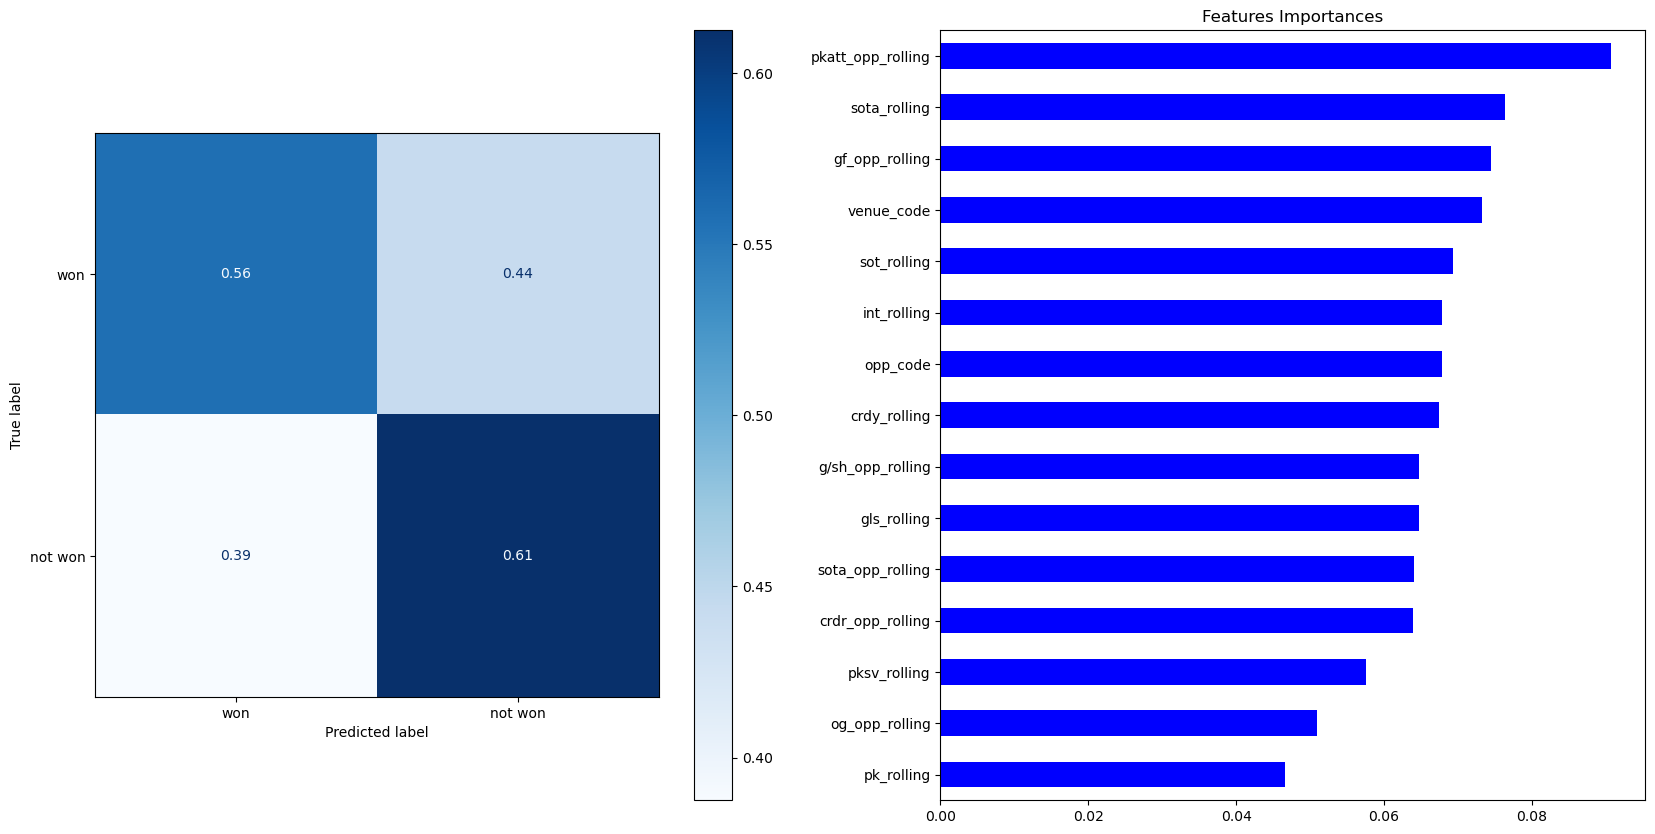

The weighted percision is 0.5921038274901657
The raw percision is:  [0.52307692 0.64473684]


In [41]:
#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='binary:logistic',
                              booster='gbtree',
                              eta = 0.001,
                              eval_metric='auc',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.09,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              scale_pos_weight = 0.75,
                              )

combined, precision_weight, precision_raw, XGB_model = train_test(XGB_model,
                                                                  df_rolling,
                                                                  trim_features,
                                                                  )

For binary classification it is best to take sample weight out and use the scale pos weight instead. 

We note that these Random Forrest and XGBoost are similar but not models not same ( Random forest uses bagging ensemble model while XGBoost uses boosting ensemble model), so it may differ sometimes in results. Now let me tell you why this happens.

When the correlation between the variables are high, XGBoost will pick one feature and may use it while breaking down the tree further(if required) and it will ignore some/all the other remaining correlated features(because we will not be able to learn different aspects of the model by using these correlated feature because it is already highly correlated with the chosen feature).

But in random forest , the tree is not built from specific features, rather there is random selection of features (by using row sampling and column sampling), and then the model in whole learn different correlations of different features. So you can see the procedure of two methods are different so you can expect them to behave little differently.

In [43]:
selected_team = 'Krasnodar' #input("Select Team ")
selected_opponent = 'Chelsea' # input("Select Op_Team ")
v_code = 1; #input('v code 1 or 0')

inference = infer(selected_team,selected_opponent,v_code,df_rolling,XGB_model,trim_features)
print(inference)

      venue_code  opp_code  gls_rolling  sot_rolling  pk_rolling  \
1242           1        93     0.217391     0.230769         0.0   

      sota_rolling  pksv_rolling  int_rolling  crdy_rolling  gf_opp_rolling  \
1242      0.485714           0.0     0.464286           0.6        0.041667   

      g/sh_opp_rolling  pkatt_opp_rolling  sota_opp_rolling  crdr_opp_rolling  \
1242          0.055944                0.0               0.2               0.0   

      og_opp_rolling  
1242             0.0  
[0]


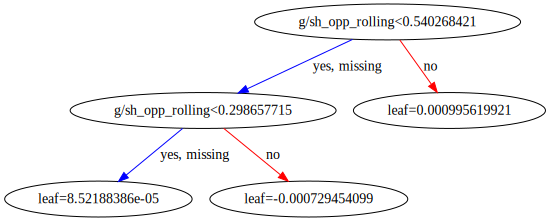

In [44]:
xgb.to_graphviz(XGB_model, num_trees=2)

### Adding the best model to Pickle


In [53]:
file = open('data/appData.pkl', 'wb')
data = [combined, precision_weight, precision_raw, XGB_model, trim_features, df_rolling]
# dump information to that file
pickle.dump(data, file)
file.close()

In [50]:
# Using plotly for the confusionmatrix
a = pd.crosstab(index=combined["actual"], columns=combined["predicted"])
#Have to divide by the sum of each row to maintain consistancy with the random forrest confusion matrix plots. 
a = a.div(a.sum(axis=1), axis = 0)
fig = px.imshow(a, color_continuous_scale='blues', text_auto=True, x = ['won', 'not won'], y = ['won','not won'])
fig.show()